# George Chen

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install nltk
import nltk

In [2]:
df = pd.read_csv("Eluvio_DS_Challenge.csv")

# Data Exploration

In [51]:
df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category,datetime_created,creation_year,creation_month,creation_day,creation_hour,creation_minute,creation_second
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews,2008-01-25 03:34:06,2008,1,25,3,34,6
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews,2008-01-25 03:34:35,2008,1,25,3,34,35
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews,2008-01-25 03:42:03,2008,1,25,3,42,3
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews,2008-01-25 03:54:50,2008,1,25,3,54,50
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews,2008-01-25 15:25:20,2008,1,25,15,25,20


In [54]:
#predict up_votes? How many? Or downvotes?
df['up_votes'].unique()

array([   3,    2,    1, ..., 2321, 6824, 3360])

In [53]:
df['down_votes'].unique()

array([0])

In [11]:
#nulls?
df.isnull().sum()

time_created    0
date_created    0
up_votes        0
down_votes      0
title           0
over_18         0
author          0
category        0
dtype: int64

In [16]:
df.dtypes

time_created     int64
date_created    object
up_votes         int64
down_votes       int64
title           object
over_18           bool
author          object
category        object
dtype: object

In [55]:
df['category'].describe()

count        509236
unique            1
top       worldnews
freq         509236
Name: category, dtype: object

# Feature Engineering

Drop unused columns

In [9]:
update_df = df.drop(['date_created','author','category','time_created'], axis = 1)

In [54]:
update_df['up_votes'].describe()

count    509236.000000
mean        112.236283
std         541.694675
min           0.000000
25%           1.000000
50%           5.000000
75%          16.000000
max       21253.000000
Name: up_votes, dtype: float64

In [66]:
np.sum(update_df['up_votes']>10000)

15

In [59]:
np.sum(update_df['up_votes']>100)

50215

In [60]:
np.sum(np.sum(update_df['up_votes']>10))

160503

In [10]:
train = update_df[["title","up_votes"]]

In [11]:
#change up_votes into two categories
train.loc[train["up_votes"] <1000, "up_votes"] = 0
train.loc[(train["up_votes"] >= 1000) , "up_votes"] = 1


/srv/conda/envs/data102/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [120]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    train["title"], train["up_votes"], test_size=0.2, random_state=42)

In [91]:
from sklearn.feature_extraction.text import CountVectorizer 

vectorizer = CountVectorizer(stop_words = "english",max_features = 10000)

In [78]:
def results(cnf_matrix):
    fp= cnf_matrix[1][0]
    tp = cnf_matrix[1][1]
    tn = cnf_matrix[0][0]
    fn = cnf_matrix[0][1]
    return {"precision" : tp/(tp+fp), "recall": tp/(tp+fn) }

# Set up pipeline for random forest

In [118]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

bow_transformer = Pipeline(steps=[('one hot', vectorizer)])
rf = Pipeline(steps=[('preprocessor', vectorizer),
                      ('classifier', RandomForestClassifier(n_estimators = 500, max_depth = 8))])

# optimize parameters for rf

In [116]:
param_grid = { 
    'classifier__n_estimators': [200, 500],
    'classifier__max_depth' : [4,5,6,7,8]}
from sklearn.model_selection import GridSearchCV
CV = GridSearchCV(rf, param_grid, n_jobs= 1, verbose = 10)
                  
CV.fit(X_train, y_train)
print(CV.best_params_)    
print(CV.best_score_)

/srv/conda/envs/data102/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] classifier__max_depth=4, classifier__n_estimators=200 ...........
[CV]  classifier__max_depth=4, classifier__n_estimators=200, score=0.643, total=  51.7s
[CV] classifier__max_depth=4, classifier__n_estimators=200 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.8s remaining:    0.0s


[CV]  classifier__max_depth=4, classifier__n_estimators=200, score=0.650, total=  52.9s
[CV] classifier__max_depth=4, classifier__n_estimators=200 ...........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


[CV]  classifier__max_depth=4, classifier__n_estimators=200, score=0.651, total=  58.3s
[CV] classifier__max_depth=4, classifier__n_estimators=500 ...........


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.7min remaining:    0.0s


[CV]  classifier__max_depth=4, classifier__n_estimators=500, score=0.649, total= 1.7min
[CV] classifier__max_depth=4, classifier__n_estimators=500 ...........


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.4min remaining:    0.0s


[CV]  classifier__max_depth=4, classifier__n_estimators=500, score=0.648, total= 1.7min
[CV] classifier__max_depth=4, classifier__n_estimators=500 ...........


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.1min remaining:    0.0s


[CV]  classifier__max_depth=4, classifier__n_estimators=500, score=0.650, total= 1.8min
[CV] classifier__max_depth=5, classifier__n_estimators=200 ...........


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  7.9min remaining:    0.0s


[CV]  classifier__max_depth=5, classifier__n_estimators=200, score=0.649, total=  54.8s
[CV] classifier__max_depth=5, classifier__n_estimators=200 ...........


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  8.8min remaining:    0.0s


[CV]  classifier__max_depth=5, classifier__n_estimators=200, score=0.647, total=  57.2s


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  9.8min remaining:    0.0s


[CV] classifier__max_depth=5, classifier__n_estimators=200 ...........
[CV]  classifier__max_depth=5, classifier__n_estimators=200, score=0.653, total= 1.0min
[CV] classifier__max_depth=5, classifier__n_estimators=500 ...........


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 10.8min remaining:    0.0s


[CV]  classifier__max_depth=5, classifier__n_estimators=500, score=0.654, total= 1.9min
[CV] classifier__max_depth=5, classifier__n_estimators=500 ...........
[CV]  classifier__max_depth=5, classifier__n_estimators=500, score=0.649, total= 1.9min
[CV] classifier__max_depth=5, classifier__n_estimators=500 ...........
[CV]  classifier__max_depth=5, classifier__n_estimators=500, score=0.654, total= 1.9min
[CV] classifier__max_depth=6, classifier__n_estimators=200 ...........
[CV]  classifier__max_depth=6, classifier__n_estimators=200, score=0.652, total=  57.2s
[CV] classifier__max_depth=6, classifier__n_estimators=500 ...........
[CV]  classifier__max_depth=6, classifier__n_estimators=500, score=0.654, total= 2.1min
[CV] classifier__max_depth=6, classifier__n_estimators=500 ...........
[CV]  classifier__max_depth=6, classifier__n_estimators=500, score=0.655, total= 2.1min
[CV] classifier__max_depth=6, classifier__n_estimators=500 ...........
[CV]  classifier__max_depth=6, classifier__n_e

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 47.7min finished


{'classifier__max_depth': 8, 'classifier__n_estimators': 500}
0.6588521390942091


# Downsample

In [68]:
#downsample
def downsample(X_train,y_train):
    #returns new X_train, y_train
    X = pd.concat([X_train, y_train], axis=1)
    small = X[y_train==0]
    big = X[y_train==1]

    small = small.sample(big.shape[0])
    new_X = pd.concat([small, big])

    y_train = new_X["up_votes"]
    X_train = new_X["title"]

In [130]:
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.fit_transform(X_test)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_vectors, y_train)
lr.score(test_vectors, y_test)

/srv/conda/envs/data102/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6666797580708507

In [131]:
#downsample result
from sklearn.metrics import confusion_matrix
y_pred = lr.predict(test_vectors)
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix_percentages = cnf_matrix/np.sum(cnf_matrix)

[Text(25.5, 0.5, 'actual'),
 Text(0.5, 7.5, 'predicted'),
 Text(0.5, 1, 'Heatmap of downsampling classification')]

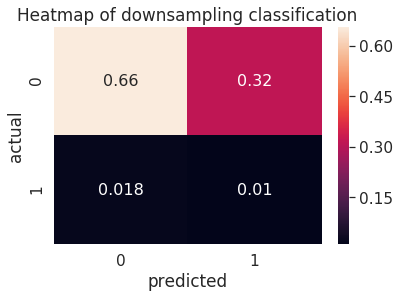

In [132]:
df_cm = pd.DataFrame(cnf_matrix_percentages, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
ax = sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
ax.set(xlabel='predicted', ylabel='actual', title = "Heatmap of downsampling classification")


In [79]:
down_res = results(cnf_matrix)

In [80]:
down_res

{'precision': 0.3766404199475066, 'recall': 0.03816489361702128}

# upsample


In [121]:
# concatenate our training data back together
from sklearn.utils import resample
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
small = X[y_train==0]
big = X[y_train==1]

upsampled = resample(big,
                          replace=True, # sample with replacement
                          n_samples=len(small), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([small, upsampled])

y_train = upsampled["up_votes"]
X_train = upsampled.drop('up_votes', axis=1)["title"]

In [122]:
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.fit_transform(X_test)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_vectors, y_train)
lr.score(test_vectors, y_test)

In [ ]:
#upsample result
from sklearn.metrics import confusion_matrix
y_pred = lr.predict(test_vectors)
cnf_matrix_up = confusion_matrix(y_test, y_pred)
cnf_matrix_percentages = cnf_matrix_up/np.sum(cnf_matrix_up)

[Text(25.5, 0.5, 'actual'),
 Text(0.5, 7.5, 'predicted'),
 Text(0.5, 1, 'Heatmap of upsampling classification')]

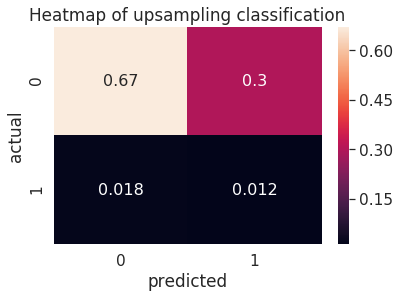

In [84]:
df_cm = pd.DataFrame(cnf_matrix_up_percentages, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
ax = sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
ax.set(xlabel='predicted', ylabel='actual', title = "Heatmap of upsampling classification")


In [85]:
up_res = results(cnf_matrix_up)
up_res

{'precision': 0.3910761154855643, 'recall': 0.037673830594184575}

# RF

## upsample

In [137]:
rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=10000, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None,...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=8,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
  

In [138]:
y_pred = rf.predict(X_test)
cnf_matrix = confusion_matrix(y_pred, y_test)

In [139]:
#rf result
cnf_matrix_percentages = cnf_matrix/np.sum(cnf_matrix)

[Text(25.5, 0.5, 'actual'),
 Text(0.5, 7.5, 'predicted'),
 Text(0.5, 1, 'Heatmap of rf classification')]

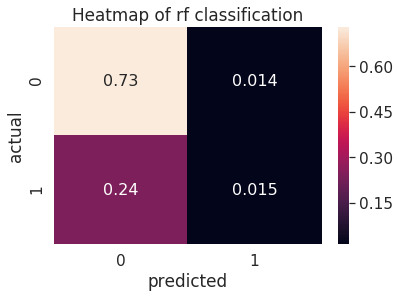

In [140]:
df_cm = pd.DataFrame(cnf_matrix_percentages, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
ax = sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
ax.set(xlabel='predicted', ylabel='actual', title = "Heatmap of rf classification")


In [141]:
results(cnf_matrix)

{'precision': 0.05737988247493951, 'recall': 0.5123456790123457}

# Analysis

I felt that number of up_votes was the best prediction task, as often one might be interested in how many views a video will get before it is posted. I focused specifically on using text features to predict this, and categorized videos into videos with a low view count <1000 views, and a high view count >1000 views.

Originally, I attempted random forest and logistic regression with tfidf, which seemed to only predict that the video would fall into the "small video category", meaning very high accuracy but no ability to predict a video in the "large view count category". 

I then tried upsampling and downsampling,which seem to affect the classification almost equally, with equal ratios of
all 4 categories of predictions(False Positive, False Negative etc.). 
With both, we achieved a precision of about .38, and a recall of about .038.

I then tried random forest on the upsampled data. This gets the benefit of a in general better model for classification,
as well as a better ratio of classes. Here, I found that we had a precision of about .06, and a recall of about .50.

Random forest induced a tradeoff of precision for recall. More relevant items were selected, but less selected items are relevant. If I were a sponsor predicting which video will "go big" I would go with the random forest model as I'm willing to take the fact that many videos will not go big that I predict to go big, but overall I will find more "big videos" than before.

As a note I had an untraditional train/test split. Since the class imbalance was huge, I both up and down sampled the minority and majority classes. Downsampling made it so that the number of test values was greater than the number of train values, so for that case specifically, I made the train/test split high so that I would have a greater amount of minority class values in my train set. For the upsampling case, there was no need to do this.

Adding datetime data might boost results further. In addition, smote resampling may increase my precision and recall.